# 🚖📊 Comprehensive Taxi & Air Pollution Analysis Notebook
This notebook guides you through an end-to-end analysis of taxi mobility and air quality data in New York, including:
1. Detailed data exploration (EDA)
2. Spatio-temporal joining via GeoHash and hourly bins
3. Pattern and correlation analysis
4. Clustering with DBSCAN and silhouette evaluation
5. Parameter sweeps to tune DBSCAN
6. A weighted-DBSCAN variant
7. Visual summaries and key findings

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geohash2 as geohash
import geopandas as gpd
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

plt.rcParams['figure.figsize'] = (10,4)
%matplotlib inline


In [101]:

# Step 1: Load zone shapefile
zones = gpd.read_file('taxi_zones.shp')

# Step 2: Compute centroids (in lat/lon)
zones = zones.to_crs(epsg=4326)  # convert to WGS84
zones['longitude'] = zones.centroid.x
zones['latitude'] = zones.centroid.y

# Step 3: Keep only required columns
zone_coords = zones[['LocationID', 'latitude', 'longitude']]

# Step 4: Save to CSV if needed
zone_coords.to_csv('zone_centroids.csv', index=False)
print("Saved 'zone_centroids.csv'")


DataSourceError: taxi_zones.shp: No such file or directory

In [51]:
import pandas as pd

# Load all 4 months of taxi data
files = [
    'green_tripdata_2021-09.parquet',
    'green_tripdata_2021-10.parquet',
    'green_tripdata_2021-11.parquet',
    'green_tripdata_2021-12.parquet'
]
taxi_df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

# Filter to AQ time range
taxi_df['lpep_pickup_datetime'] = pd.to_datetime(taxi_df['lpep_pickup_datetime'])
taxi_df = taxi_df[
    (taxi_df['lpep_pickup_datetime'] >= '2021-09-10') &
    (taxi_df['lpep_pickup_datetime'] <= '2021-12-15')
]

# Load correct zone centroid file
zone_coords = pd.read_csv('zone_centroids.csv')  # Must contain 'LocationID', 'latitude', 'longitude'

# Merge coordinates into taxi_df based on PULocationID
taxi_df = taxi_df.merge(zone_coords, left_on='PULocationID', right_on='LocationID', how='left')

# ✅ Fix column names after merge
taxi_df = taxi_df.rename(columns={
    'lpep_pickup_datetime': 'timestamp',
    'latitude': 'pickup_latitude',
    'longitude': 'pickup_longitude'
})

# Select only useful columns
taxi_df = taxi_df[['timestamp', 'pickup_latitude', 'pickup_longitude',
                   'passenger_count', 'trip_distance',
                   'fare_amount', 'tip_amount', 'total_amount']]

# Save to CSV
taxi_df.to_csv('filtered_taxi_with_coordinates.csv', index=False)

print("✅ Saved as filtered_taxi_with_coordinates.csv")


✅ Saved as filtered_taxi_with_coordinates.csv


In [102]:
# Load cleaned taxi and air quality data with correct datetime parsing
taxi_df = pd.read_csv('new_taxi_data.csv', parse_dates=['timestamp'])
aq_df = pd.read_csv('aq_data.csv', parse_dates=['time'])

print('Taxi shape:', taxi_df.shape)
print('AQ shape:', aq_df.shape)


Taxi shape: (342260, 8)
AQ shape: (169999, 31)


In [103]:
# Select useful columns from taxi data and rename timestamp
taxi_df = taxi_df[['timestamp', 'passenger_count', 'trip_distance',
                   'fare_amount', 'tip_amount', 'total_amount',
                   'pickup_latitude', 'pickup_longitude']]

# Select useful columns from AQ data (renamed 'time' to 'timestamp' earlier)
aq_df = aq_df[['time', 'latitude', 'longitude', 'temperature', 'humidity', 'pm25']]


In [104]:
# Print column names
print("Taxi Data Columns:")
print(taxi_df.columns.tolist())

print("\nAir Quality Data Columns:")
print(aq_df.columns.tolist())

Taxi Data Columns:
['timestamp', 'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'pickup_latitude', 'pickup_longitude']

Air Quality Data Columns:
['time', 'latitude', 'longitude', 'temperature', 'humidity', 'pm25']


In [105]:
# Rename columns in taxi data
taxi_df = taxi_df.rename(columns={
    'timestamp': 'timestamp',
    'pickup_latitude': 'latitude',
    'pickup_longitude': 'longitude'
})

# Rename columns in air quality data
aq_df = aq_df.rename(columns={
    'time': 'timestamp',
    'latitude': 'latitude',
    'longitude': 'longitude'
})


In [106]:
# Print column names
print("Taxi Data Columns:")
print(taxi_df.columns.tolist())

print("\nAir Quality Data Columns:")
print(aq_df.columns.tolist())

Taxi Data Columns:
['timestamp', 'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'latitude', 'longitude']

Air Quality Data Columns:
['timestamp', 'latitude', 'longitude', 'temperature', 'humidity', 'pm25']


## 2. Exploratory Data Analysis (EDA)
### 2.1 Taxi Data Exploration

In [107]:
taxi_df.head()

,timestamp,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,latitude,longitude
0,2021-09-10 00:02:31,1.0,0.81,4.5,1.16,6.96,40.708051,-73.828712
1,2021-09-10 00:05:18,1.0,2.81,11.0,2.46,14.76,40.721432,-73.847669
2,2021-09-10 00:03:32,1.0,0.69,8.0,0.00,8.30,40.827013,-73.948522
3,2021-09-10 00:14:26,1.0,2.52,10.5,2.36,14.16,40.695338,-73.986086
4,2021-09-10 00:40:58,1.0,1.56,7.0,1.66,9.96,40.685634,-73.986114


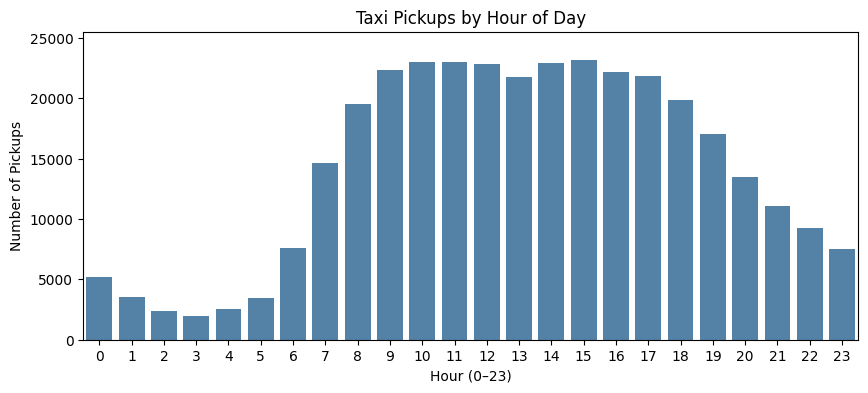

In [108]:
# Taxi pickups by hour
taxi_df['hour'] = taxi_df['timestamp'].dt.hour

plt.figure(figsize=(10, 4))
sns.countplot(x='hour', data=taxi_df, color='steelblue')
plt.title('Taxi Pickups by Hour of Day')
plt.xlabel('Hour (0–23)')
plt.ylabel('Number of Pickups')
plt.ylim(0, taxi_df['hour'].value_counts().max() * 1.1)  # Optional: dynamic limit
plt.show()


In [109]:
# NYC bounding box filter
taxi_df = taxi_df[
    (taxi_df['latitude'].between(40.5, 41.0)) & 
    (taxi_df['longitude'].between(-74.3, -73.7))
]


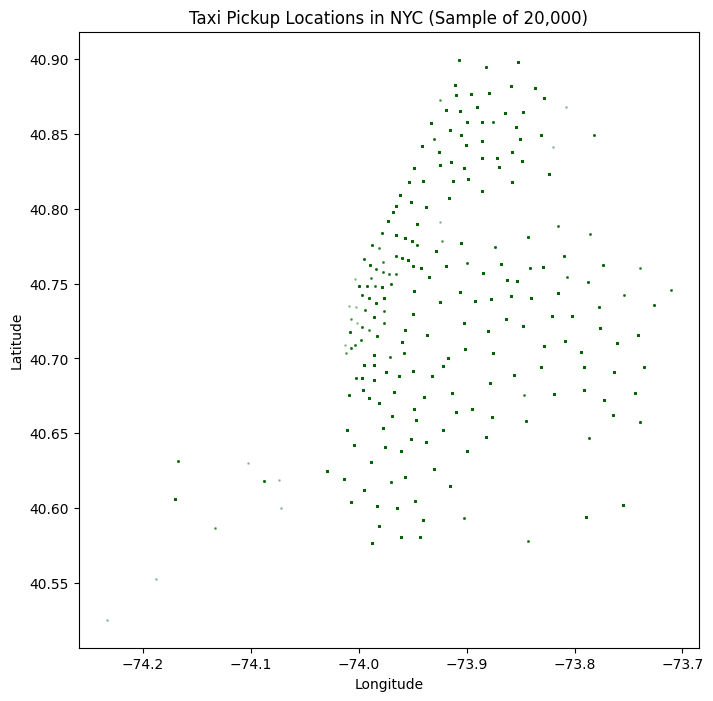

In [110]:
# Sample 20,000 records
sample = taxi_df.sample(20000)

# Plot pickup locations
plt.figure(figsize=(8, 8))
plt.scatter(
    sample['longitude'],
    sample['latitude'],
    s=1,
    alpha=0.3,
    color='darkgreen'
)
plt.title('Taxi Pickup Locations in NYC (Sample of 20,000)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


### 2.2 Air Quality Data Exploration

In [111]:
aq_df.head()

,timestamp,latitude,longitude,temperature,humidity,pm25
0,1631277304,40.847672,-73.869316,23.7,57.3,4.508813
1,1631277308,40.847668,-73.869316,23.7,57.8,5.462420
2,1631277313,40.847649,-73.869362,23.7,57.8,5.154881
3,1631277318,40.847649,-73.869362,23.6,57.6,4.508813
4,1631277323,40.847649,-73.869362,23.6,57.5,5.539503


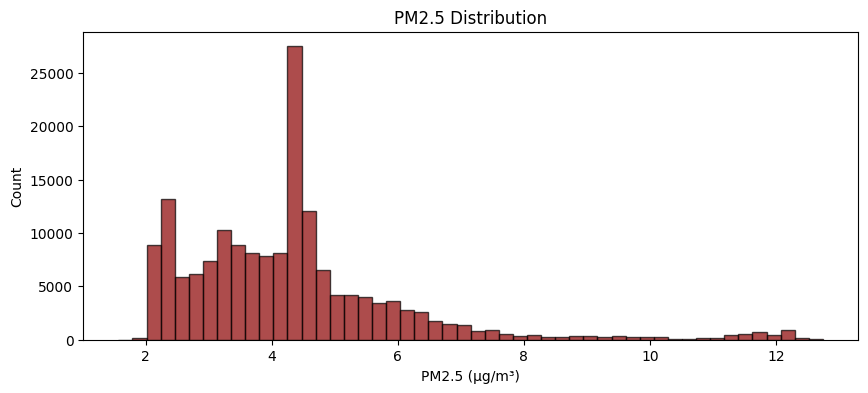

In [112]:
# 1) PM2.5 distribution with Matplotlib
plt.figure(figsize=(10,4))
plt.hist(aq_df['pm25'].values, bins=50, color='darkred', edgecolor='black', alpha=0.7)
plt.title('PM2.5 Distribution')
plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('Count')
plt.show()


In [114]:

# Sample DataFrame with Unix timestamps
# Replace this with your DataFrame
data = {
    'timestamp': [1631277304, 1631363704, 1631450104],  # Example Unix timestamps
    'value': [100, 200, 300]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Convert Unix timestamps to regular datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Show the DataFrame with converted datetime
print(df)


            timestamp  value
0 2021-09-10 12:35:04    100
1 2021-09-11 12:35:04    200
2 2021-09-12 12:35:04    300


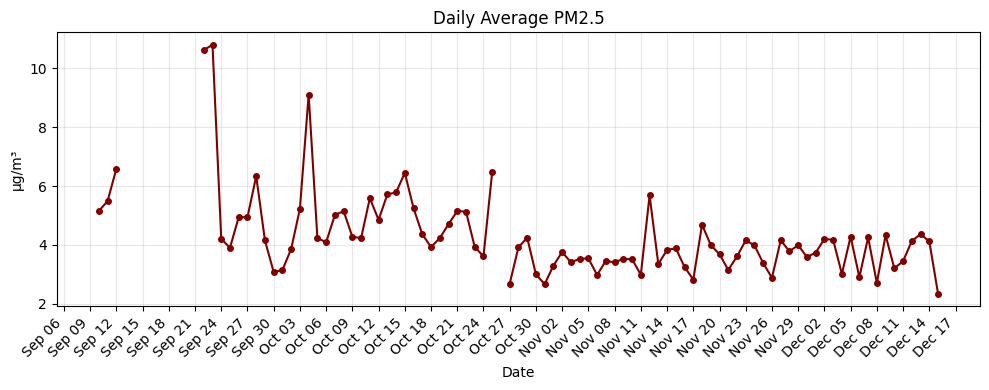

In [117]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Ensure 'timestamp' is a datetime object if not already
aq_df['timestamp'] = pd.to_datetime(aq_df['timestamp'], errors='coerce', unit='s')

# Resample daily PM2.5 values
daily_pm = aq_df.set_index('timestamp')['pm25'].resample('D').mean()

# Prepare for plotting
fig, ax = plt.subplots(figsize=(10, 4))

# Convert the index to Python datetime
dates = daily_pm.index.to_pydatetime()
values = daily_pm.values

# Plotting the data
ax.plot(dates, values, color='maroon', marker='o', markersize=4)

# Add title and labels
ax.set_title('Daily Average PM2.5')
ax.set_xlabel('Date')
ax.set_ylabel('µg/m³')

# Add grid
ax.grid(alpha=0.3)

# Improve date formatting
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.autofmt_xdate(rotation=45, ha='right')

# Ensure layout is tight
plt.tight_layout()

# Show the plot
plt.show()


In [118]:
# Print column names
print("Taxi Data Columns:")
print(taxi_df.columns.tolist())

print("\nAir Quality Data Columns:")
print(aq_df.columns.tolist())

Taxi Data Columns:
['timestamp', 'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'latitude', 'longitude', 'hour']

Air Quality Data Columns:
['timestamp', 'latitude', 'longitude', 'temperature', 'humidity', 'pm25']


## 3. Spatio-Temporal Join via GeoHash

In [119]:
# Print all column names for both datasets
print("Taxi Data Columns:")
print(taxi_df.columns)

print("\nAir Quality Data Columns:")
print(aq_df.columns)


Taxi Data Columns:
Index(['timestamp', 'passenger_count', 'trip_distance', 'fare_amount',
       'tip_amount', 'total_amount', 'latitude', 'longitude', 'hour'],
      dtype='object')

Air Quality Data Columns:
Index(['timestamp', 'latitude', 'longitude', 'temperature', 'humidity',
       'pm25'],
      dtype='object')


In [122]:
PREC = 5  # Use coarser spatial resolution for better matching

# Ensure that both DataFrames have 'timestamp' column and create geohash
for df, name in [(taxi_df, 'Taxi'), (aq_df, 'Air Quality')]:
    # For Taxi Data, ensure 'timestamp' column exists
    if name == 'Taxi':
        if 'timestamp' not in df.columns:
            print(f"Error: No 'timestamp' column found in {name} data.")
    
    # For Air Quality Data, ensure 'timestamp' exists (not 'time')
    elif name == 'Air Quality':
        if 'timestamp' not in df.columns:
            print(f"Error: No 'timestamp' column found in {name} data.")
    
    # Ensure 'timestamp' is datetime format and add 'hour' and 'geohash'
    df['timestamp'] = pd.to_datetime(df['timestamp'])  # Ensure 'timestamp' is datetime
    df['hour'] = df['timestamp'].dt.floor('h')         # Floor to the hour
    df['geohash'] = df.apply(lambda r: geohash.encode(r['latitude'], r['longitude'], PREC), axis=1)

# 🔎 Check how many common (geohash, hour) keys exist
taxi_keys = set(zip(taxi_df['geohash'], taxi_df['hour']))
aq_keys = set(zip(aq_df['geohash'], aq_df['hour']))
common_keys = taxi_keys & aq_keys
print("Matching (geohash, hour) pairs:", len(common_keys))

# ✅ (Optional) Show sample of the data
display(taxi_df[['timestamp', 'latitude', 'longitude', 'geohash', 'hour']].head())
display(aq_df[['timestamp', 'latitude', 'longitude', 'geohash', 'hour']].head())


Matching (geohash, hour) pairs: 1007


,timestamp,latitude,longitude,geohash,hour
0,2021-09-10 00:02:31,40.708051,-73.828712,dr5rx,2021-09-10
1,2021-09-10 00:05:18,40.721432,-73.847669,dr5rx,2021-09-10
2,2021-09-10 00:03:32,40.827013,-73.948522,dr72m,2021-09-10
3,2021-09-10 00:14:26,40.695338,-73.986086,dr5rs,2021-09-10
4,2021-09-10 00:40:58,40.685634,-73.986114,dr5rk,2021-09-10


,timestamp,latitude,longitude,geohash,hour
0,2021-09-10 12:35:04,40.847672,-73.869316,dr72r,2021-09-10 12:00:00
1,2021-09-10 12:35:08,40.847668,-73.869316,dr72r,2021-09-10 12:00:00
2,2021-09-10 12:35:13,40.847649,-73.869362,dr72r,2021-09-10 12:00:00
3,2021-09-10 12:35:18,40.847649,-73.869362,dr72r,2021-09-10 12:00:00
4,2021-09-10 12:35:23,40.847649,-73.869362,dr72r,2021-09-10 12:00:00


In [123]:
# Check column names in both DataFrames
print("Taxi Data Columns:", taxi_df.columns)
print("Air Quality Data Columns:", aq_df.columns)


Taxi Data Columns: Index(['timestamp', 'passenger_count', 'trip_distance', 'fare_amount',
       'tip_amount', 'total_amount', 'latitude', 'longitude', 'hour',
       'geohash'],
      dtype='object')
Air Quality Data Columns: Index(['timestamp', 'latitude', 'longitude', 'temperature', 'humidity', 'pm25',
       'hour', 'geohash'],
      dtype='object')


### 3.1 Aggregate by (geohash, hour)

In [124]:
# 3.2 Aggregate & join on (geohash, hour)
# — Re‐floor with lowercase 'h' to silence the warning
taxi_df['hour'] = taxi_df['timestamp'].dt.floor('h')
aq_df['hour'] = aq_df['timestamp'].dt.floor('h')

# — Taxi: count pickups per cell‐hour
taxi_agg = (
    taxi_df
    .groupby(['geohash', 'hour'])
    .size()
    .rename('pickup_count')
    .reset_index()
)

# — Air quality: average PM2.5 per cell‐hour
aq_agg = (
    aq_df
    .groupby(['geohash', 'hour'])['pm25']
    .mean()
    .rename('mean_pm25')
    .reset_index()
)

# — Inner join: only times/cells where we have both
joined = pd.merge(taxi_agg, aq_agg, on=['geohash', 'hour'], how='inner')

# Preview the result
print("Joined shape:", joined.shape)
display(joined.head())


Joined shape: (1007, 4)


,geohash,hour,pickup_count,mean_pm25
0,dr5rt,2021-10-29 14:00:00,3,3.187280
1,dr5ry,2021-10-29 13:00:00,11,3.084182
2,dr5rz,2021-09-22 14:00:00,2,11.387078
3,dr5rz,2021-09-22 15:00:00,3,10.522379
4,dr72j,2021-09-23 14:00:00,81,10.045421


## 4. Pattern & Correlation Analysis

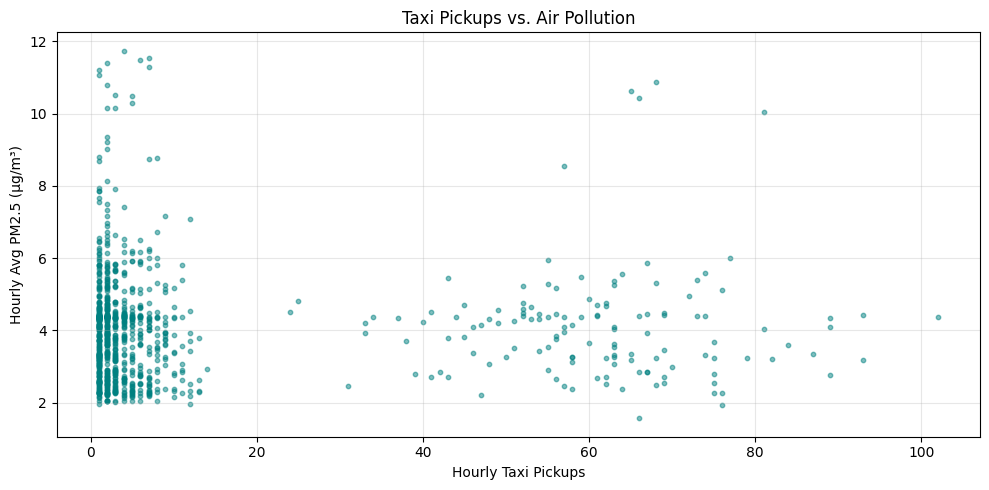

Pearson correlation (pickups vs PM2.5): 0.01


In [125]:

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(
    joined['pickup_count'],
    joined['mean_pm25'],
    alpha=0.5,
    s=10,
    color='teal'
)
plt.xlabel('Hourly Taxi Pickups')
plt.ylabel('Hourly Avg PM2.5 (µg/m³)')
plt.title('Taxi Pickups vs. Air Pollution')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Compute Pearson correlation
r = joined['pickup_count'].corr(joined['mean_pm25'])
print(f"Pearson correlation (pickups vs PM2.5): {r:.2f}")


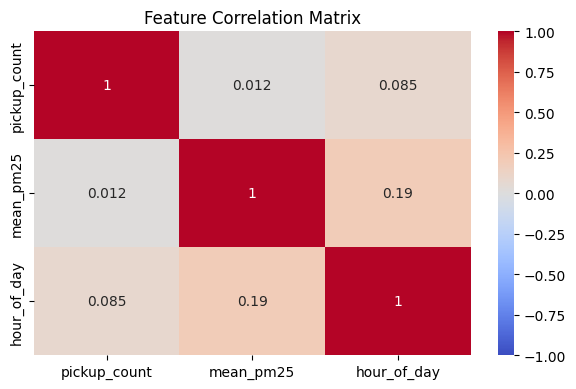

In [126]:
# 4.2 Correlation matrix heatmap (including time of day)
# add hour_of_day feature
joined['hour_of_day'] = joined['hour'].dt.hour

corr_mat = joined[['pickup_count','mean_pm25','hour_of_day']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(
    corr_mat, 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, vmax=1
)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


## 5. DBSCAN Clustering & Evaluation

In [127]:
# 5.1a) Compute centroids for each cell‐hour from taxi_df
centroids = (
    taxi_df
    .groupby(['geohash','hour'])[['latitude','longitude']]
    .mean()
    .reset_index()
)

In [128]:
# 5.1b) Merge those centroids into joined
joined_coords = pd.merge(
    joined,
    centroids,
    on=['geohash','hour'],
    how='left'
)

In [129]:
# 5.1c) Now prepare X with lat, lon, pm25, pickups, hour_of_day
X = np.vstack([
    joined_coords['latitude'],
    joined_coords['longitude'],
    joined_coords['mean_pm25'],
    joined_coords['pickup_count'],
    joined_coords['hour'].dt.hour
]).T

In [130]:
# 5.2 Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Feature matrix shape:", X_scaled.shape)

Feature matrix shape: (1007, 5)


In [131]:
# 5.3 DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(X_scaled)
joined_coords['cluster'] = db.labels_

In [132]:
# 5.4 Silhouette
mask = joined_coords['cluster'] != -1
score = silhouette_score(X_scaled[mask], joined_coords.loc[mask,'cluster'])
print(f"DBSCAN silhouette score: {score:.3f}")

DBSCAN silhouette score: 0.401


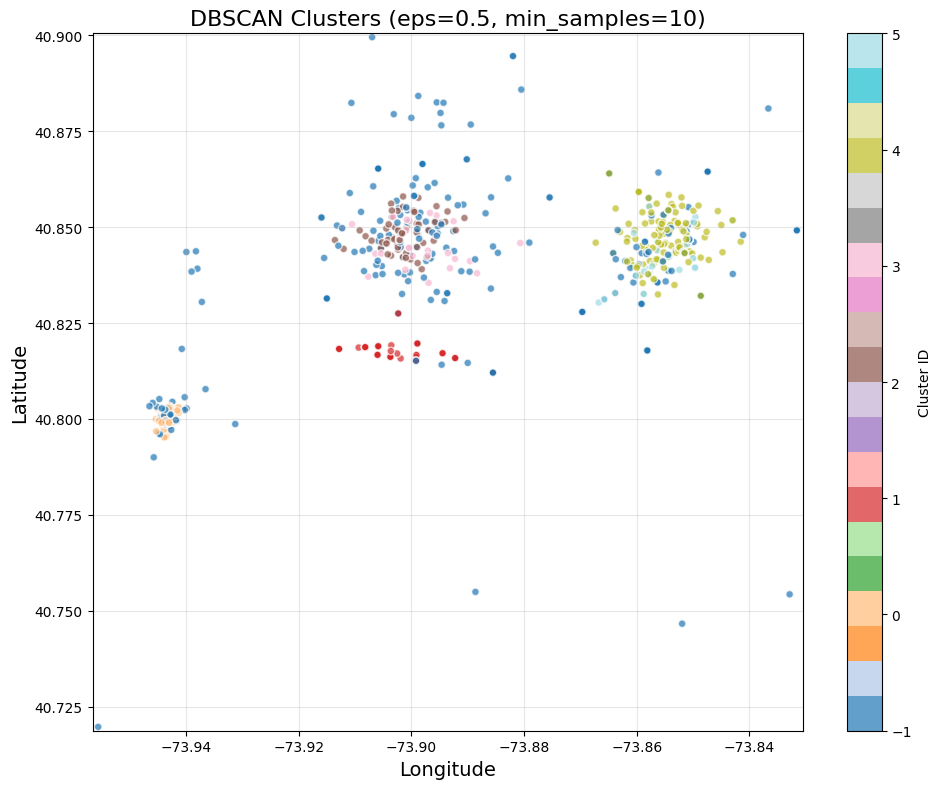

In [137]:

# 5.5 Plot a sample of clusters
# Check the available rows and sample accordingly
sample_size = min(20000, len(joined_coords))  # Ensure the sample size doesn't exceed the DataFrame size
sample = joined_coords.sample(sample_size, random_state=42)

# Create a figure and axis for plotting
plt.figure(figsize=(10, 8))

# Scatter plot with improved aesthetics
scatter = plt.scatter(
    sample['longitude'],
    sample['latitude'],
    c=sample['cluster'],
    cmap='tab20',  # Color map for clusters
    s=30,  # Increased point size for visibility
    alpha=0.7,  # Transparency to reduce overlap
    edgecolors='w',  # White edge color to distinguish points better
)

# Title and labels for better understanding
plt.title('DBSCAN Clusters (eps=0.5, min_samples=10)', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Add a color bar to show cluster labels
plt.colorbar(scatter, label='Cluster ID', orientation='vertical')

# Adjust axis limits to zoom into the region where clusters are visible
plt.xlim(sample['longitude'].min() - 0.001, sample['longitude'].max() + 0.001)
plt.ylim(sample['latitude'].min() - 0.001, sample['latitude'].max() + 0.001)

# Make the grid visible with lighter lines for better visibility
plt.grid(True, alpha=0.3)

# Show the plot with tight layout for clarity
plt.tight_layout()
plt.show()
